# Image Classification with pre-trained CNN Models

All models are included in [Keras](https://keras.io/applications/#documentation-for-individual-models) are were trained on ImageNet.

Test with:
  * VGG16 (224x224, 0.713 acc top1, 528 MB, 23 layer)
  * ResNet50 (224x224, 0.749 acc top1, 99 MB, 168 layer)
  * [InceptionV3](https://keras.io/applications/#inceptionv3) (299x299, 0.779 acc top1, 92 MB, 159 layer)
  * Xception (299x299, 0.790 acc top1, 88 MB, 126 layer)
  * InceptionResNetV2 (299x299, 0.803 acc top1, 215 MB, 572 layer)
  * NasNetLarge (331x331, 0.825 acc top1, 343 MB, ?)
  * NasNetMobile (224x224, 0.744 acc top1, 23 MB, ?)

based on:

  * [Jason Brownlee: How to Use The Pre-Trained VGG Model to Classify Objects in Photographs](https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/) (2017-11-08)
  * [Keras deep learning models wirh pre-trained weights](https://keras.io/applications/)

In [1]:
import time
import keras, tensorflow

print('Keras', keras.__version__)
print('TensorFlow', tensorflow.__version__)

Using TensorFlow backend.


Keras 2.2.4
TensorFlow 1.12.0


## Image Download

In [2]:
image_urls = ["https://c1.staticflickr.com/6/5259/5393739840_938b56b479_b.jpg", # strawberry + kiwi
              "https://c1.staticflickr.com/5/4850/31617922037_22c26f0db6_c.jpg",   # salad
              "https://c1.staticflickr.com/4/3422/3757087582_e42cac55f4_b.jpg",
              "https://c1.staticflickr.com/5/4544/39053395052_5b2503930b_b.jpg" # pie
             ]

image_dir = "../data/images/"

import os
if not os.path.exists(image_dir):
    os.makedirs(image_dir)

In [3]:
from urllib.request import urlretrieve

for i, url in enumerate(image_urls):
    filename = image_dir + "img{}.jpg".format(i+1)
    if not os.path.exists(filename):
        try:
            print(urlretrieve (url, filename))
        except (IOError, ValueError) as e:
            print(e)
    else:
        print('found', filename)

found ../data/images/img1.jpg
found ../data/images/img2.jpg
found ../data/images/img3.jpg
found ../data/images/img4.jpg


## Image Prepocessing

In [4]:
from keras.preprocessing.image import load_img, img_to_array

img_files = [f for f in os.listdir(image_dir)]

images224 = [load_img(image_dir+f, target_size=(224, 224)) for f in img_files]
images299 = [load_img(image_dir+f, target_size=(299, 299)) for f in img_files]

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_images(images):
    fig, axs = plt.subplots(1, len(images), figsize=(16,8), subplot_kw={'xticks': [], 'yticks': []})

    for i, img in enumerate(images224):
        axs[i].imshow(img)
        #axs[i].set_axis_off()

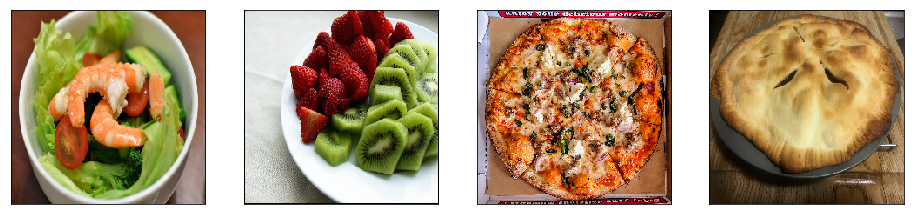

In [6]:
plot_images(images224)

In [7]:
def prepare_img(image):
    image = img_to_array(image)
    image = image.reshape((1,) + image.shape)
    return image

In [8]:
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input

def predict(model, image):
    image = keras.applications.vgg16.preprocess_input(image)
    yhat = model.predict(image)
    labels = decode_predictions(yhat)
    return labels

def plot_predictions(labels):
    fig, axs = plt.subplots(1, len(labels), sharex=True, figsize=(12,2))

    for i, lab in enumerate(labels):
        categories = [t[1] for t in lab[0]]
        values     = [t[2] for t in lab[0]]
        y_pos      = list(range(0, len(categories)))
        
        axs[i].barh(y_pos, values, color='green')
        axs[i].set_yticks(y_pos)
        axs[i].set_yticklabels(categories)
        axs[i].invert_yaxis()
        axs[i].set_title("{} ({:.2f}%)".format(categories[0], values[0]*100))
    fig.tight_layout()
    plt.show()

# VGG16

  * **Input:** 224x224
  * **Features/Filters:** 25,088 (Flatten 7x7x512)
  * **Predictions:** 2xDense/4096 + Dense/1000
  * **Parameters:** 138.3M

In [9]:
from keras.applications.vgg16 import VGG16
model_vgg16 = VGG16(include_top=True, weights='imagenet')

In [10]:
#model_vgg16.summary()

In [11]:
# warm-up
labels_224 = [predict(model_vgg16, prepare_img(img)) for img in images224]

start_time = time.time()
labels_224 = [predict(model_vgg16, prepare_img(img)) for img in images224]
print("--- took %s seconds ---" % (time.time() - start_time))

--- took 2.296416997909546 seconds ---


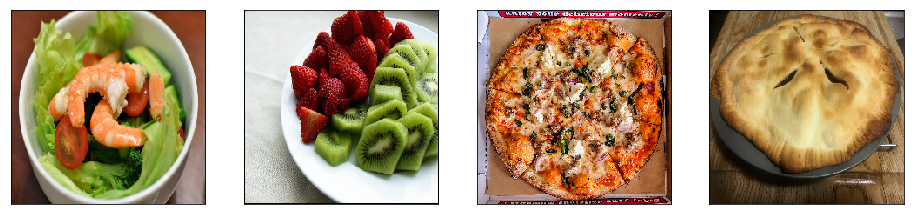

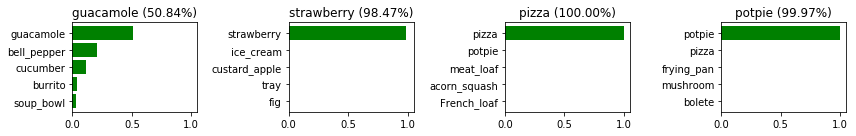

In [12]:
plot_images(images224)
plot_predictions(labels_224)

# ResNet50

  * **Input:** 224x224
  * **Features/Filters:** 2048 (global average pooling)
  * **Prediction:** Dense/1000
  * **Parameters:** 25.6M

In [13]:
from keras.applications.resnet50 import ResNet50
model_res50 = ResNet50(include_top=True, weights='imagenet')

In [14]:
#model_res50.summary()

In [15]:
start_time = time.time()
labels_224 = [predict(model_res50, prepare_img(img)) for img in images224]
print("--- took %s seconds ---" % (time.time() - start_time))

--- took 1.6060888767242432 seconds ---


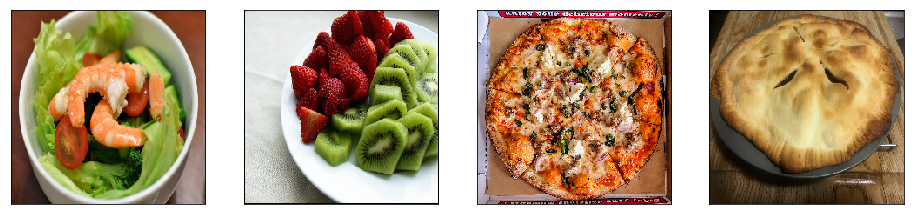

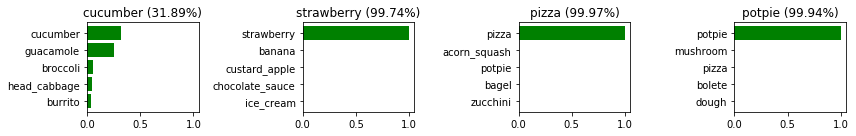

In [16]:
plot_images(images224)
plot_predictions(labels_224)

# InceptionNetV3

  * **Input:** flexible - the [documentation](https://keras.io/applications/#inceptionv3) says "Default input size is 299x299", but 224x224 seems to work better!
  * **Features/Filters:** 2048 (global average pooling)
  * **Prediction:** Dense/1000
  * **Parameters:** 23.9M

In [17]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import decode_predictions

model_iv3 = InceptionV3(include_top=True, weights='imagenet')  # no need to specify input shape (it's flexible)

In [18]:
#model_iv3.summary()

In [19]:
def predict_iv3(model, image):
    image = keras.applications.inception_v3.preprocess_input(image)
    yhat = model.predict(image)
    labels = keras.applications.inception_v3.decode_predictions(yhat)
    return labels

In [20]:
# warm-up
labels_224 = [predict_iv3(model_iv3, prepare_img(img)) for img in images224]
labels_299 = [predict_iv3(model_iv3, prepare_img(img)) for img in images299]

start_time = time.time()
labels_224 = [predict_iv3(model_iv3, prepare_img(img)) for img in images224]
print("--- took %s seconds ---" % (time.time() - start_time))

start_time = time.time()
labels_299 = [predict_iv3(model_iv3, prepare_img(img)) for img in images299]
print("--- took %s seconds ---" % (time.time() - start_time))

--- took 0.6157593727111816 seconds ---
--- took 1.1442961692810059 seconds ---


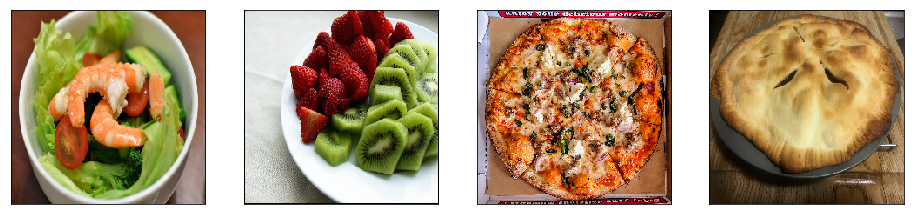

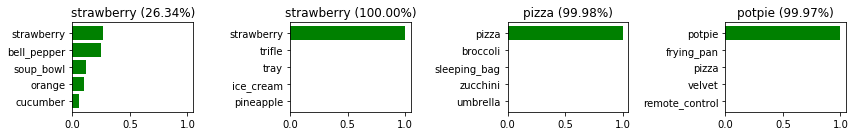

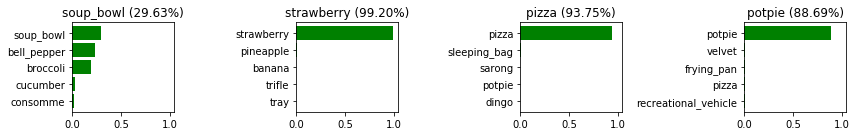

In [21]:
plot_images(images224)
plot_predictions(labels_224)
plot_predictions(labels_299)

## Xception

  * **Input:** flexible - the [documentatio](https://keras.io/applications/#xception) says "Default input size is 299x299", but 224x224 seems to work better!
  * **Features/Filters:** 2048 (global average pooling)
  * **Prediciton:** Dense/1000
  * **Params:** 22.9M

In [22]:
from keras.applications.xception import Xception

model_xcp = Xception(include_top=True, weights='imagenet')

In [23]:
#model_xcp.summary()

In [24]:
# warm-up
labels_224 = [predict_iv3(model_xcp, prepare_img(img)) for img in images224]
labels_299 = [predict_iv3(model_xcp, prepare_img(img)) for img in images299]

start_time = time.time()
labels_224 = [predict_iv3(model_xcp, prepare_img(img)) for img in images224]
print("--- took %s seconds ---" % (time.time() - start_time))

start_time = time.time()
labels_299 = [predict_iv3(model_xcp, prepare_img(img)) for img in images299]
print("--- took %s seconds ---" % (time.time() - start_time))

--- took 1.2384917736053467 seconds ---
--- took 2.117112159729004 seconds ---


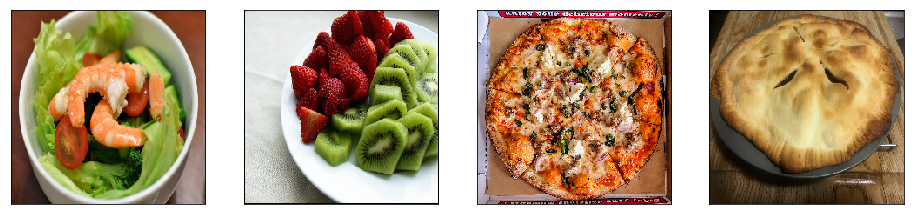

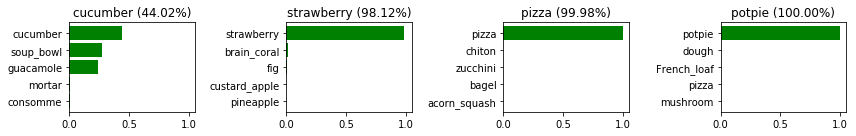

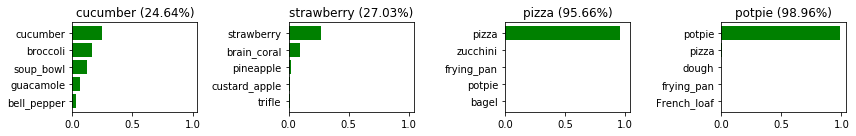

In [25]:
plot_images(images224)
plot_predictions(labels_224)
plot_predictions(labels_299)

## NASNet Mobile

  * **Input:** 224x224
  * **Features/Filters:** 1056 (global average pooling)
  * **Prediction:** Dense/1000
  * **Parameters:** 5.3M

In [26]:
from keras.applications.nasnet import NASNetMobile
model_nasM = NASNetMobile(include_top=True, weights='imagenet')

In [27]:
#model_nasM.summary()

In [28]:
# warm-up
labels_224 = [predict_iv3(model_nasM, prepare_img(img)) for img in images224]

start_time = time.time()
labels_224 = [predict_iv3(model_nasM, prepare_img(img)) for img in images224]
print("--- took %s seconds ---" % (time.time() - start_time))

--- took 0.5531086921691895 seconds ---


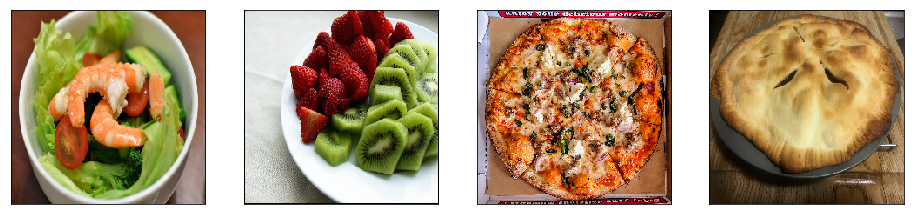

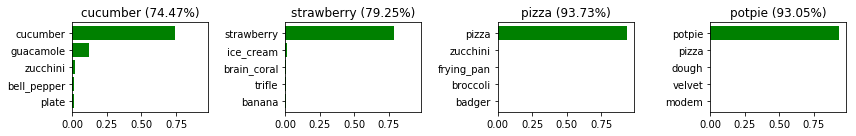

In [29]:
plot_images(images224)
plot_predictions(labels_224)